# Temporal distribution of clusters of traders in FX implementation

This notebook contains a Python implementation of investigation of clustering distribution and its temporal evolution of retail investors, based on trading timing similarity. It covers only the dynamic scenario where we do not restrict the number of present traders. Therefore the latter are increasing with time. For the static scenario one needs to  slightly modify the code.

0) Contruct Dataset for SVN

1) Apply SVN

2) Given clustering algo create clusters

3) Ewens distribution fit and other visualisations

4) Application of aggregation algorithm and clusterised version of the latter


In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

In [1]:
%load_ext autoreload
%autoreload 2

#### Imports

In [2]:
import py_files.SVN as svn
import py_files.Ewens as ewens
from py_files.DirTree import tree
from py_files.DapraForAA import DAPRA_for_dynamic_clusters_AA
from tqdm import tqdm_notebook
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.1.1"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.1.1\bin\x64" + ";" + os.environ["PATH"]
import rpy2
from rpy2.robjects import pandas2ri, packages
pandas2ri.activate()
stats = packages.importr('stats')
from os import listdir
from os.path import isfile, join
import networkx as nx
from sklearn.preprocessing import LabelEncoder
#overlapping
from karateclub.community_detection.overlapping import EgoNetSplitter, NNSED, DANMF, MNMF, BigClam, SymmNMF
from karateclub.community_detection.non_overlapping import EdMot, LabelPropagation, SCD, GEMSEC
from pathlib import Path
from itertools import islice
import sys
sys.setrecursionlimit(2000)

In [4]:
%load_ext rpy2.ipython

C:\Users\actio\miniconda3\envs\tensorflow-gpu\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [5]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

#### Folders and paths 

In [19]:
tree("" , level=2, limit_to_directories=True)


├── .ipynb_checkpoints
├── data
├── json_files
├── karateclub
│   ├── community_detection
│   ├── dataset
│   ├── graph_embedding
│   ├── node_embedding
│   ├── utils
│   └── __pycache__
├── notebooks
│   └── .ipynb_checkpoints
├── output
│   ├── dynamic
│   ├── dynamic_clusters
│   └── tosvn
├── py_files
│   └── __pycache__
├── r_files
└── __pycache__

20 directories


## Contruct Dataset for SVN

In [5]:
#parameters
with open('json_files\constructsvn.json', 'r') as fp:
    parameters_dict = json.load(fp)
relevant_symbols = ['EUR/USD'] 
delta_t = [10,15,30,60,120,180,  360, 1440]
cuts=[100,500,1000]

In [6]:
svn.ContructDatasetforSVN(parameters_dict,relevant_symbols,cuts, delta_t)

  0%|          | 0/24 [00:00<?, ?it/s]

## Apply SVN
- download R

- in anaconda prompt type $ conda install -c r r-essentials

- in anaconda prompt type $ pip install rpy2

In [7]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### 1000 cutoff

In [8]:
df10,df15,df30,df60,df120,df180,df360,df1440=svn.LoadDynamicDataforSVN(1000)
r_from_pd_df10 = ro.conversion.py2rpy(df10)
r_from_pd_df15 = ro.conversion.py2rpy(df15)
r_from_pd_df30 = ro.conversion.py2rpy(df30)
r_from_pd_df60 = ro.conversion.py2rpy(df60)
r_from_pd_df120 = ro.conversion.py2rpy(df120)
r_from_pd_df180 = ro.conversion.py2rpy(df180)
r_from_pd_df360 = ro.conversion.py2rpy(df360)
r_from_pd_df1440 = ro.conversion.py2rpy(df1440)

(50976, 403) (33984, 403) (16992, 403) (8496, 403) (4248, 403) (2832, 403) (1416, 403) (708, 403)


In [9]:
%%R -i r_from_pd_df10 -i r_from_pd_df15 -i r_from_pd_df30 -i r_from_pd_df60 -i r_from_pd_df120 -i r_from_pd_df180 -i r_from_pd_df360 -i r_from_pd_df1440

source("r_files/funs.R")
st="6months_2weeks_EURUSD_"
windowsize=120
windowroll=10
b=88
iter=50
cut=1000
getSVNlinks(st,cut,windowsize,windowroll,b,iter)
 

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: 'igraph'


R[write to console]: The following objects are masked from 'package:stats':

    decompose, spectrum


R[write to console]: The following object is masked from 'package:base':

    union


R[write to console]: Loading required package: memoise



### 500 cutoff

In [10]:
df10,df15,df30,df60,df120,df180,df360,df1440=svn.LoadDynamicDataforSVN(500)
r_from_pd_df10 = ro.conversion.py2rpy(df10)
r_from_pd_df15 = ro.conversion.py2rpy(df15)
r_from_pd_df30 = ro.conversion.py2rpy(df30)
r_from_pd_df60 = ro.conversion.py2rpy(df60)
r_from_pd_df120 = ro.conversion.py2rpy(df120)
r_from_pd_df180 = ro.conversion.py2rpy(df180)
r_from_pd_df360 = ro.conversion.py2rpy(df360)
r_from_pd_df1440 = ro.conversion.py2rpy(df1440)

(62136, 885) (41424, 885) (20712, 885) (10356, 885) (5178, 885) (3452, 885) (1726, 885) (863, 885)


In [28]:
%%R -i r_from_pd_df10 -i r_from_pd_df15 -i r_from_pd_df30 -i r_from_pd_df60 -i r_from_pd_df120 -i r_from_pd_df180 -i r_from_pd_df360 -i r_from_pd_df1440

source("r_files/funs.R")
st="6months_2weeks_EURUSD_"
windowsize=120
windowroll=10
b=243
iter=50

cut=500
getSVNlinks(st,cut,windowsize,windowroll,b,iter)
 

### 100 cutoff

In [29]:
df10,df15,df30,df60,df120,df180,df360,df1440=svn.LoadDynamicDataforSVN(100)
r_from_pd_df10 = ro.conversion.py2rpy(df10)
r_from_pd_df15 = ro.conversion.py2rpy(df15)
r_from_pd_df30 = ro.conversion.py2rpy(df30)
r_from_pd_df60 = ro.conversion.py2rpy(df60)
r_from_pd_df120 = ro.conversion.py2rpy(df120)
r_from_pd_df180 = ro.conversion.py2rpy(df180)
r_from_pd_df360 = ro.conversion.py2rpy(df360)
r_from_pd_df1440 = ro.conversion.py2rpy(df1440)

(68112, 4345) (45408, 4345) (22704, 4345) (11352, 4345) (5676, 4345) (3784, 4345) (1892, 4345) (946, 4345)


In [32]:
%%R -i r_from_pd_df10 -i r_from_pd_df15 -i r_from_pd_df30 -i r_from_pd_df60 -i r_from_pd_df120 -i r_from_pd_df180 -i r_from_pd_df360 -i r_from_pd_df1440

source("r_files/funs.R")
st="6months_2weeks_EURUSD_"
windowsize=120
windowroll=10
b=326
iter=50
cut=100
getSVNlinks(st,cut,windowsize,windowroll,b,iter)
 

##  Given clustering algo create clusters
### We construct clusters using
- Constructing clusters using igraph  R library (https://rdrr.io/cran/igraph/man/ look for  functions starting with cluster_..)
- Constructing clusters using karakte club python library (https://github.com/benedekrozemberczki/karateclub)
#### Constructing clusters using igraph R library

- cluster_walktrap() Community strucure via short random walks, see http://arxiv.org/abs/physics/0512106
- cluster_edge_betweenness() aka Girvan-Newman algorithm: Community structure detection based on edge betweenness. Consecutively each edge with the highest betweenness is removed from the graph.
- cluster_fast_greedy() aka Clauset-Newman-Moore algorithm. Agglomerative algorithm that greedily optimises modularity. Fast, but might get stuck in a local optimum.
- cluster_spinglass() Finding communities in graphs based on statistical meachanics http://arxiv.org/abs/cond-mat/0603718
- cluster_leading_eigen() This function tries to find densely connected subgraphs in a graph by calculating the leading non-negative eigenvector of the modularity matrix of the graph.  https://arxiv.org/abs/physics/0605087
- cluster_infomap() Minimizes the expected description length of a random walker trajectory
- cluster_label_prop() Fast – This is a fast, nearly linear time algorithm for detecting community structure in networks. In works by labeling the vertices with unique labels and then updating the labels by majority voting in the neighborhood of the vertex.  https://arxiv.org/abs/0709.2938
- cluster_louvain() Fast, hierarchical. Each vertex is moved to the community with which it achieves the highest contribution to modularity (agglomeration in k-means?)
- cluster_optimal() Slow, optimal communities based on maximal modularity score.


In [34]:
%%R

#cluster_methods_liste<-c( "spinglass","walktrap","infomap","louvain","edge_betweenness","fast_greedy","label_prop","leading_eigen")

name<-"EURUSD"
minutes_liste<-minutes_liste<-c(10,15,30,60,120,180,360,1440)
cut_liste<-c(100,500,1000)
window_liste<-c("6months_2weeks")
mypath_liste<-c("output/dynamic/")
cluster_methods_liste<-c( "infomap" )
createRclusters(name,minutes_liste,cut_liste,window_liste,mypath_liste,cluster_methods_liste)



[1] "EURUSD ****min: 10 ****cut: 100 ****window: 6months_2weeks ****path: output/dynamic/ ****method: infomap"
================================================================================[1] "EURUSD ****min: 15 ****cut: 100 ****window: 6months_2weeks ****path: output/dynamic/ ****method: infomap"
================================================================================[1] "EURUSD ****min: 30 ****cut: 100 ****window: 6months_2weeks ****path: output/dynamic/ ****method: infomap"
================================================================================[1] "EURUSD ****min: 60 ****cut: 100 ****window: 6months_2weeks ****path: output/dynamic/ ****method: infomap"
================================================================================[1] "EURUSD ****min: 120 ****cut: 100 ****window: 6months_2weeks ****path: output/dynamic/ ****method: infomap"
================================================================================[1] "EURUSD ****min: 180 ****cut: 100 ****wi

#### Constructing clusters using karakte club python library


Overlapping Community Detection

- DANMF from Ye et al.: Deep Autoencoder-like Nonnegative Matrix Factorization for Community Detection (CIKM 2018)
-  M-NMF from Wang et al.: Community Preserving Network Embedding (AAAI 2017)
-  Ego-Splitting from Epasto et al.: Ego-splitting Framework: from Non-Overlapping to Overlapping Clusters (KDD 2017)
-   NNSED from Sun et al.: A Non-negative Symmetric Encoder-Decoder Approach for Community Detection (CIKM 2017)
-  BigClam from Yang and Leskovec: Overlapping Community Detection at Scale: A Nonnegative Matrix Factorization Approach (WSDM 2013)
-   SymmNMF from Kuang et al.: Symmetric Nonnegative Matrix Factorization for Graph Clustering (SDM 2012)

Non-Overlapping Community Detection
 -   GEMSEC from Rozemberczki et al.: GEMSEC: Graph Embedding with Self Clustering (ASONAM 2019)

 -   EdMot from Li et al.: EdMot: An Edge Enhancement Approach for Motif-aware Community Detection (KDD 2019)

 -   SCD from Prat-Perez et al.: High Quality, Scalable and Parallel Community Detectionfor Large Real Graphs (WWW 2014)

 -   Label Propagation from Raghavan et al.: Near Linear Time Algorithm to Detect Community Structures in Large-Scale Networks (Physics Review E 2007)
 


In [11]:

#minutes_liste=[10,15,30,60,120,180,360,1440]
#cut_liste=[100,500,1000]
#cluster_methods_liste =['EgoNetSplitter','NNSED','DANMF','MNMF','BigClam','SymmNMF','EdMot','LabelPropagation','SCD','GEMSEC']



name="EURUSD"

minutes_liste=[10,15,30,60,120,180,360,1440]
cut_liste=[100,500,1000]
window_liste=["6months_2weeks"]
mypath_liste=["output\\dynamic\\"]
cluster_methods_liste =['EgoNetSplitter']# add more if you want
svn.createPclusters(mypath_liste,window_liste,cut_liste,minutes_liste,cluster_methods_liste)

EURUSD 10 100 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 15 100 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 30 100 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 60 100 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 120 100 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 180 100 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 360 100 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 1440 100 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 10 500 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 15 500 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 30 500 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 60 500 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 120 500 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 180 500 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 360 500 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 1440 500 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 10 1000 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 15 1000 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 30 1000 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 60 1000 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 120 1000 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 180 1000 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 360 1000 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

EURUSD 1440 1000 6months_2weeks EgoNetSplitter output\dynamic\


  0%|          | 0/51 [00:00<?, ?it/s]

## Ewens distribution fit and other visualisations



C:\Users\actio\Desktop\RHUL PhD\Clustering_paper\py_files\Ewens.py:495: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


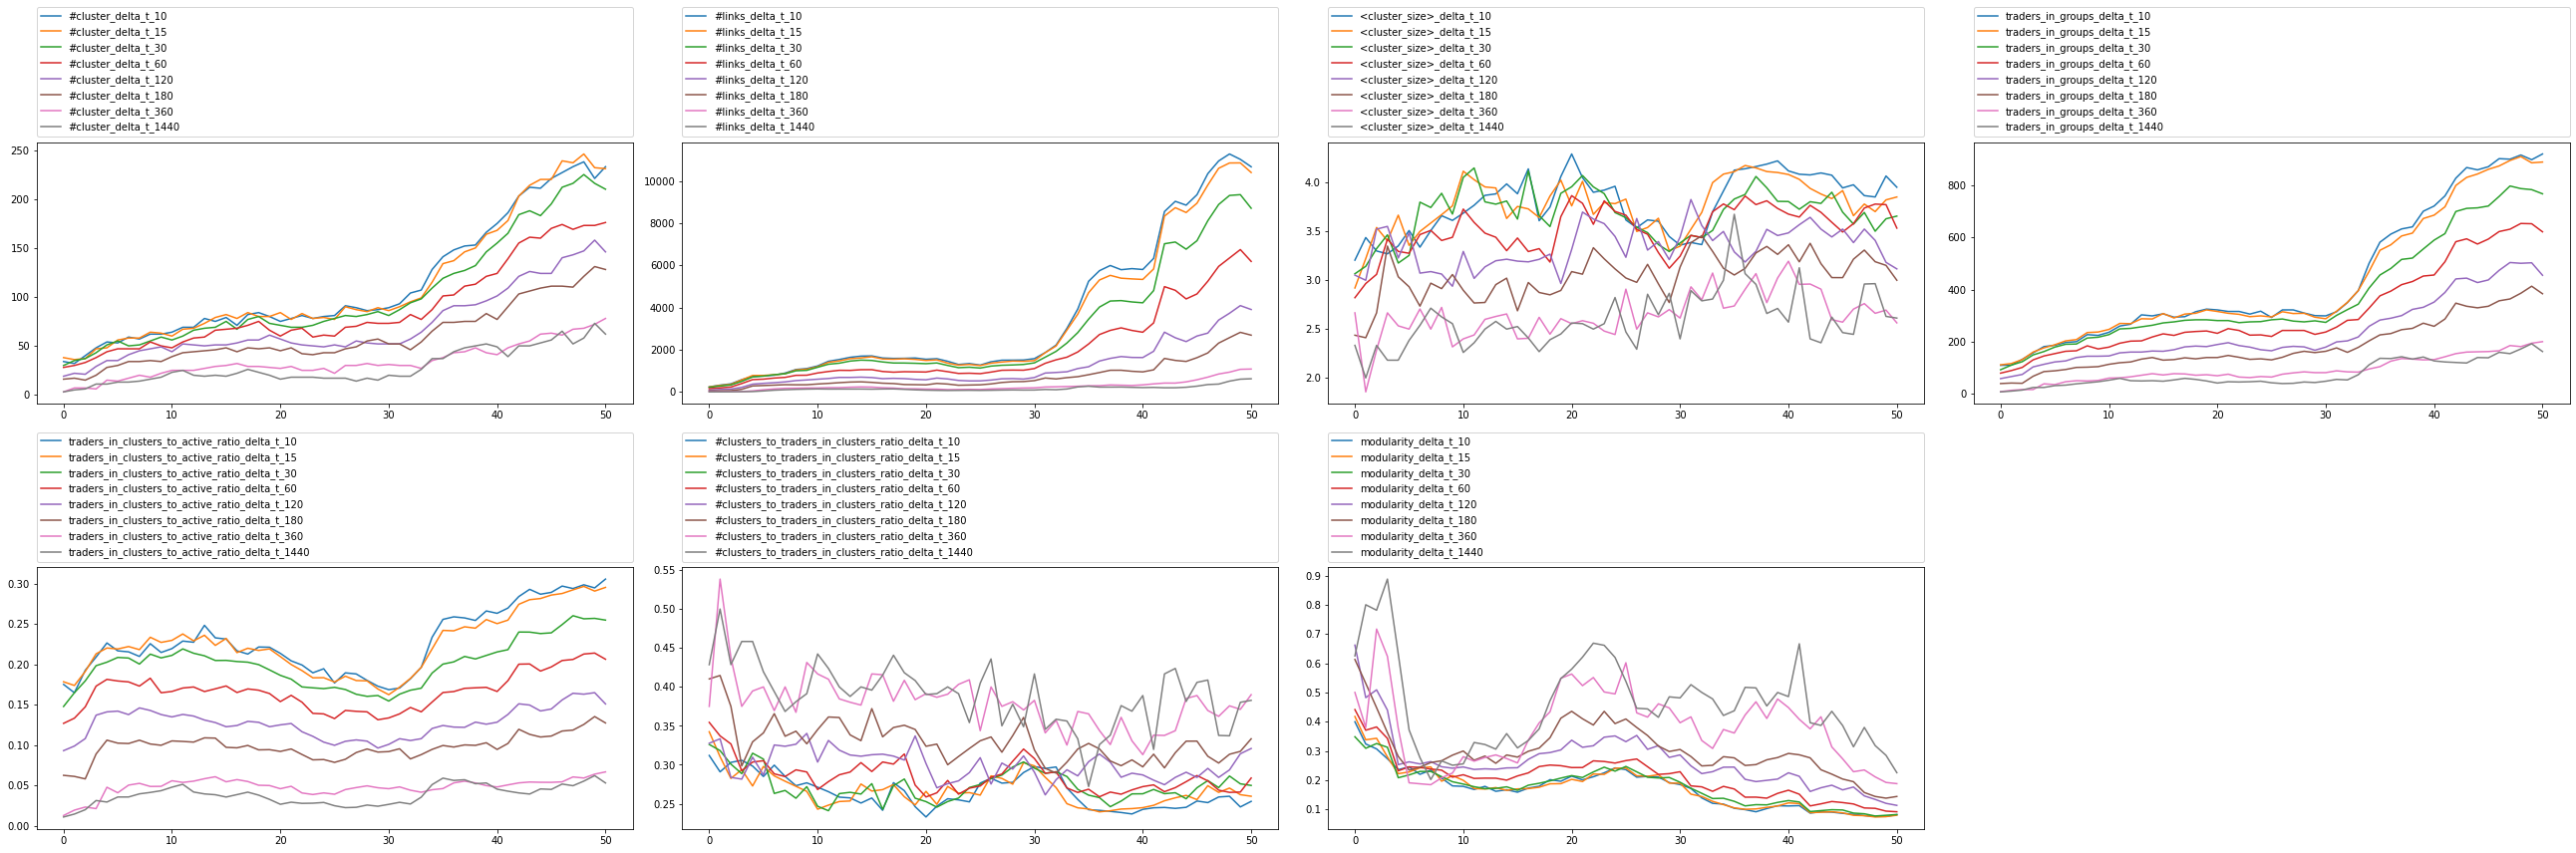

In [20]:
ewens.plot_stats("6months_2weeks_EURUSD" ,100 ) 

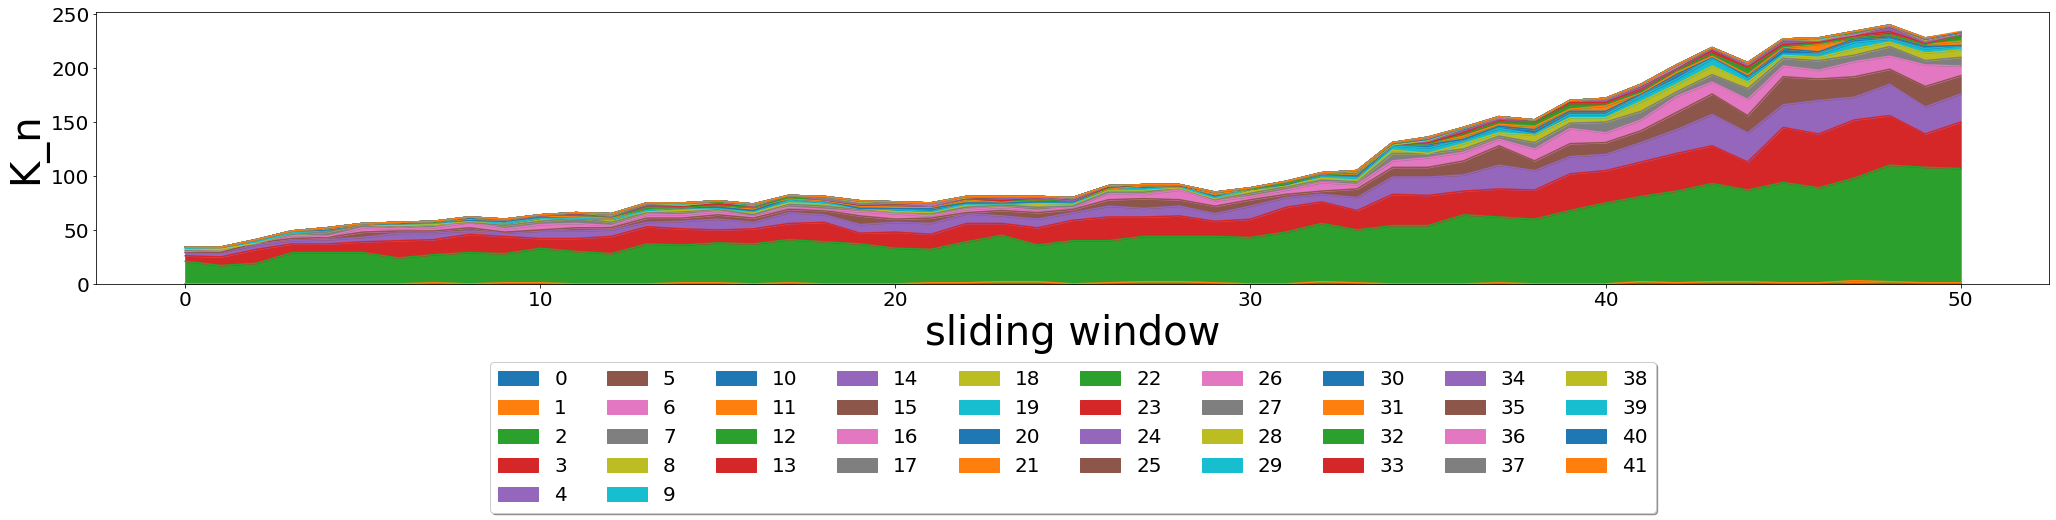

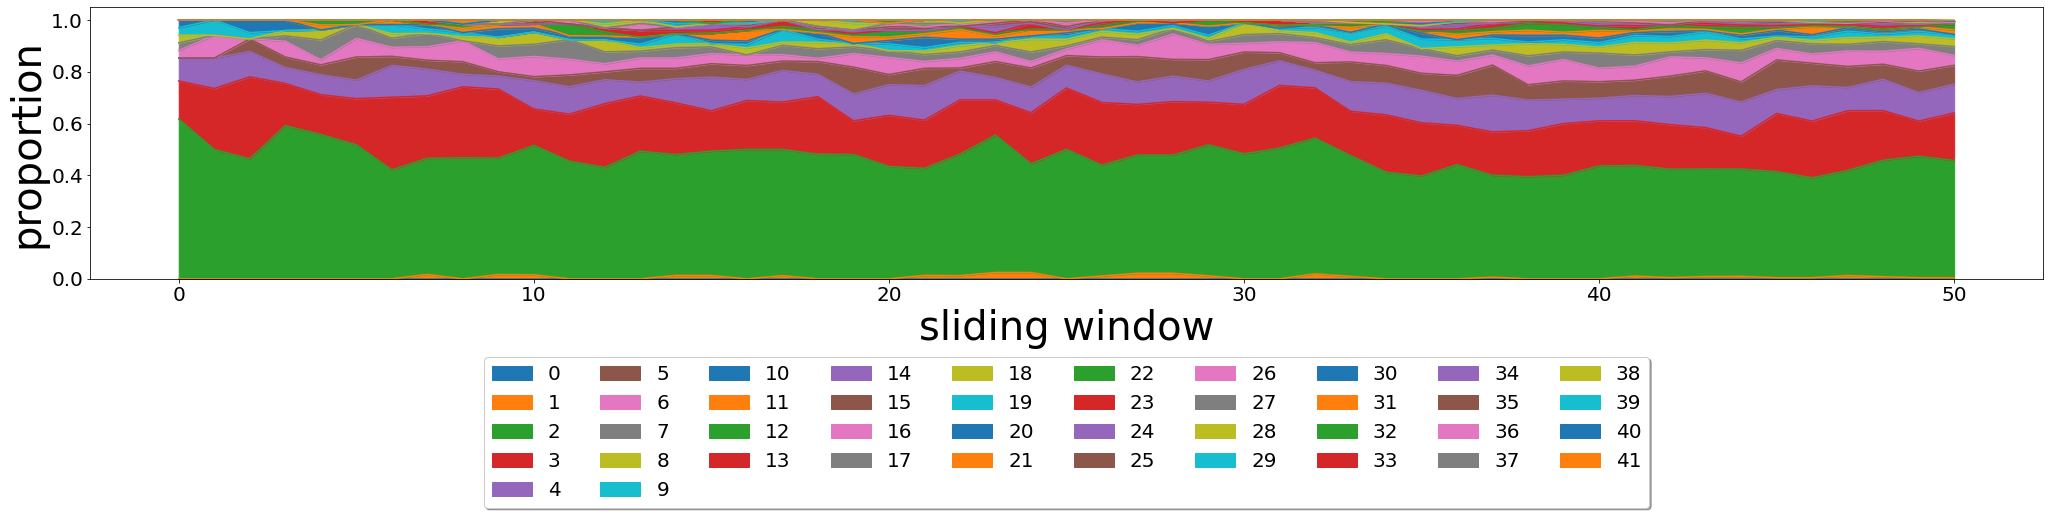

<Figure size 432x288 with 0 Axes>

In [8]:
ewens.proportionvectorplot("EURUSD", 10, 100, "6months_2weeks_EURUSD" , "infomap" )

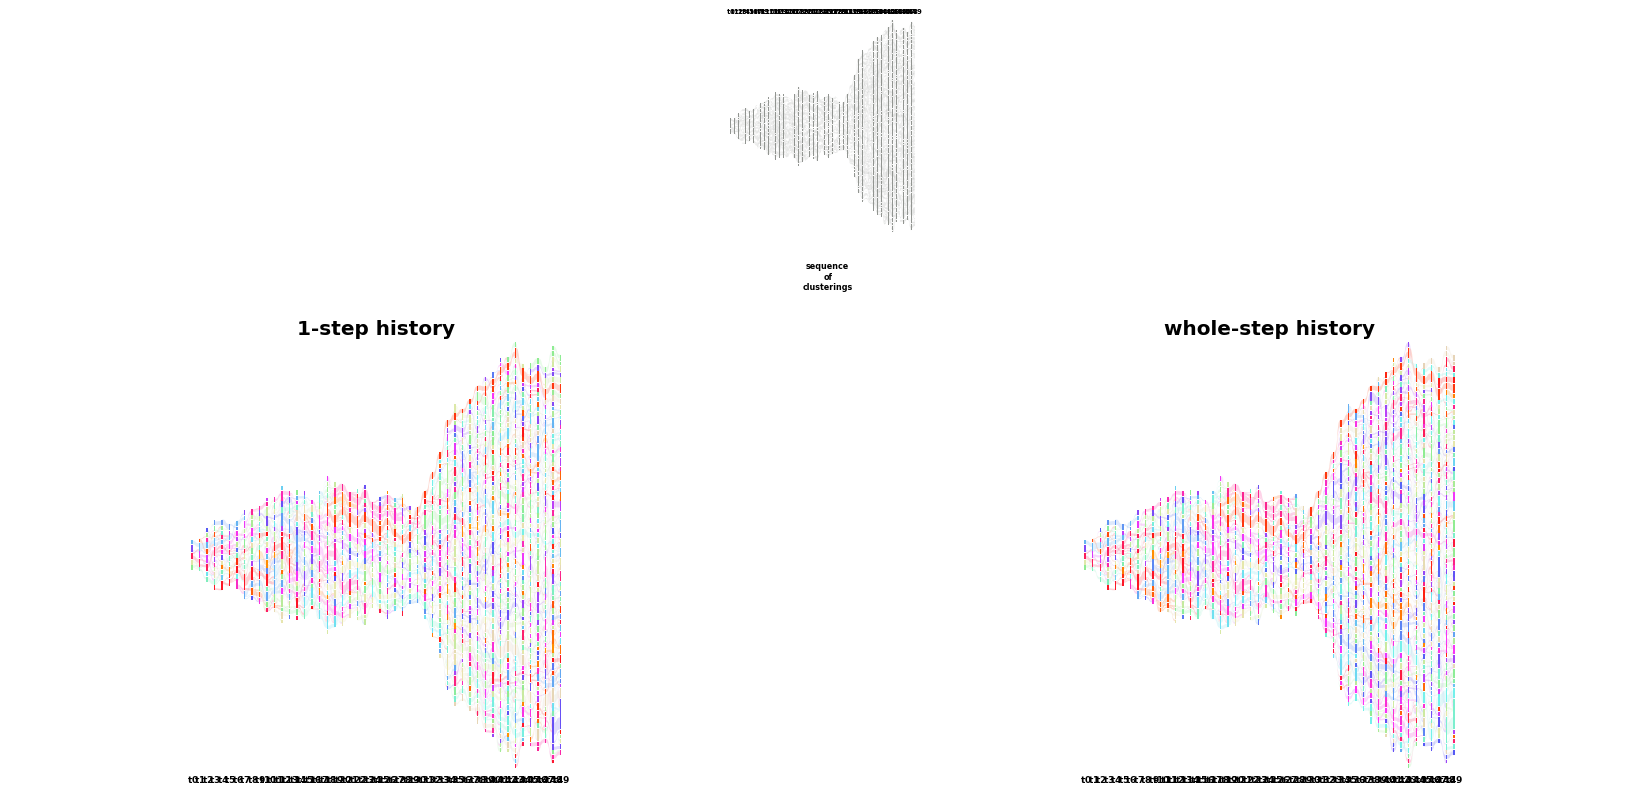

ommited steps because of errors:  1


C:\Users\actio\Desktop\RHUL PhD\Clustering_paper\py_files\Ewens.py:871: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [11]:
ewens.alluvial("EURUSD",10,100,"6months_2weeks","infomap",5)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

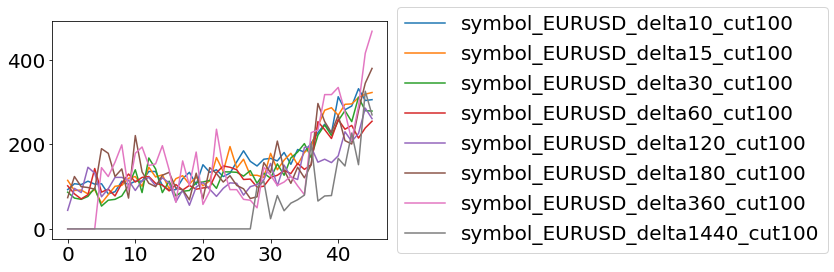

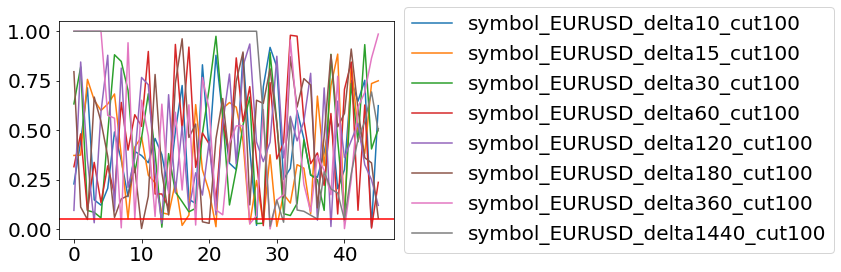

No handles with labels found to put in legend.


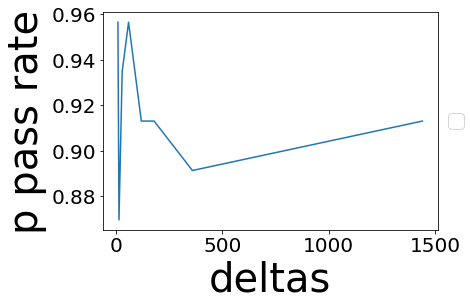

In [25]:
a,b,c=ewens.chitest_fit_ewens("EURUSD",100)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

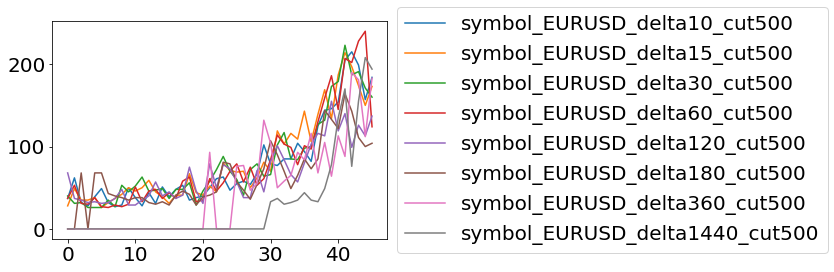

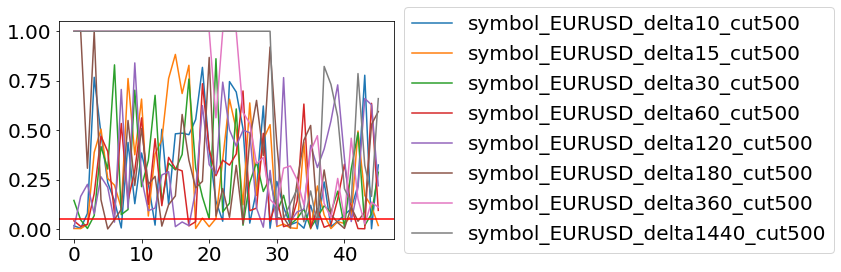

No handles with labels found to put in legend.


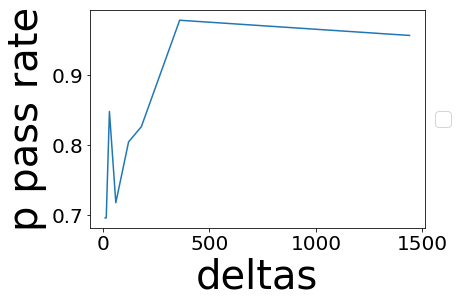

In [60]:
d, e, f = ewens.chitest_fit_ewens("EURUSD", 500)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

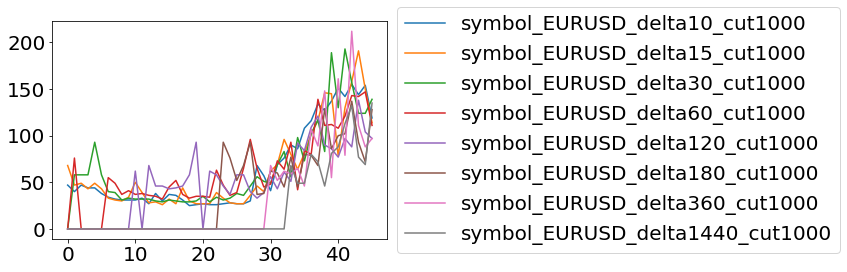

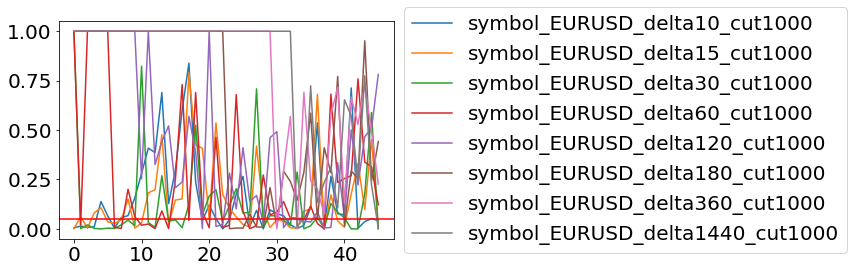

No handles with labels found to put in legend.


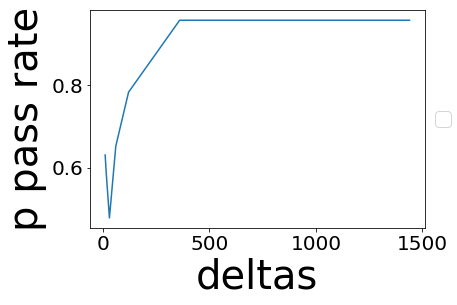

In [28]:
g, h, i = ewens.chitest_fit_ewens("EURUSD", 1000)

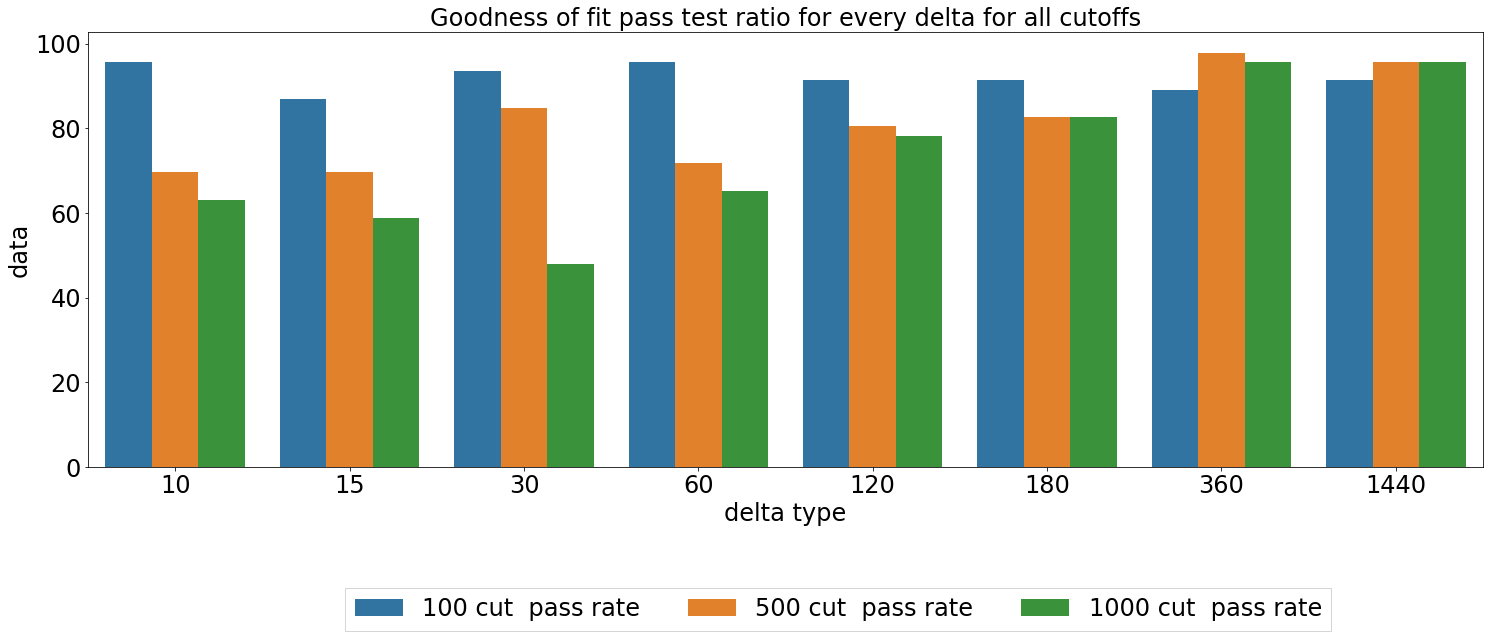

In [66]:
ewens.passtestplot2(a,b,c,d,e,f,g,h,i)

## Application of aggregation algorithm and clusterised version of the latter

#### Apply DAPRA

In [69]:
DAPRA_for_dynamic_clusters_AA(1000)

--------------------Prepare trades df--------------
403
--------------------Prepare prices df--------------
--------------------Prepare for DAPRA--------------
------------------ LOOP-----------------------


  0%|          | 0/403 [00:00<?, ?it/s]